<a href="https://colab.research.google.com/github/arvinfatemi/xOVS288wVKBQFYVD/blob/main/HappyCustomers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

In [3]:
survey_data = pd.read_csv('ACME-HappinessSurvey2020.csv')
survey_data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [32]:
# Let's change variable names to something more descriptive
survey_data.rename(columns={'X1': 'on_time_delivery', 'X2': 'content_as_expected','X3': 'all_items_ordered','X4': 'perceived_value','X5': 'courier_experience','X6': 'app_usability'}, inplace=True)

In [24]:
survey_data.describe()

,Y,on_time_delivery,content_as_expected,all_items_ordered,perceived_value,courier_experience,app_usability
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [25]:
survey_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Y                    126 non-null    int64
 1   on_time_delivery     126 non-null    int64
 2   content_as_expected  126 non-null    int64
 3   all_items_ordered    126 non-null    int64
 4   perceived_value      126 non-null    int64
 5   courier_experience   126 non-null    int64
 6   app_usability        126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [26]:
X = survey_data.drop(columns=['Y'])
Y = survey_data['Y']

### Before going to exploratory data analysis, we'll test some models on the data. This will serve as a baseline performance with which we can compare tha accuracy of future models

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42
)

In [21]:
models = {
    "Logistic Regression":  LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest":        RandomForestClassifier(n_estimators=100, random_state=42),
    "SVC":                  SVC(random_state=42),
    "XGBoost":              XGBClassifier(
                               use_label_encoder=False,
                               eval_metric="logloss",
                               random_state=42
                           )
}

In [19]:
def test_models(models, X_train, X_test, y_train, y_test):
  results = []
  for name, model in models.items():

      model.fit(X_train, y_train)

      y_pred = model.predict(X_test)
      test_acc = accuracy_score(y_test, y_pred)
      results.append({
          "Model": name,
          "Hold-out Acc": test_acc
      })
  return pd.DataFrame(results)

In [52]:
test_models(models, X_train, X_test, y_train, y_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:33:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Hold-out Acc
0,Logistic Regression,0.461538
1,Random Forest,0.615385
2,SVC,0.461538
3,XGBoost,0.653846


We tested Logistic Regression, Random Forest, SVC, and xgboost and the accuracy is between 46% to 65%. The goal is to reach 73%.

## Exploratory Data Analysis

### Let's first check the distribution of values/answers for each question. And within that, the distribution of happy vs. unhappy customers

In [27]:
for x in X.columns:
  print(x, X[x].value_counts())

on_time_delivery on_time_delivery
5    65
4    40
3    20
1     1
Name: count, dtype: int64
content_as_expected content_as_expected
3    42
2    34
1    27
4    17
5     6
Name: count, dtype: int64
all_items_ordered all_items_ordered
3    55
4    33
5    17
2    14
1     7
Name: count, dtype: int64
perceived_value perceived_value
4    53
3    41
5    25
2     5
1     2
Name: count, dtype: int64
courier_experience courier_experience
4    50
5    31
3    22
2    16
1     7
Name: count, dtype: int64
app_usability app_usability
5    57
4    47
3    20
2     1
1     1
Name: count, dtype: int64


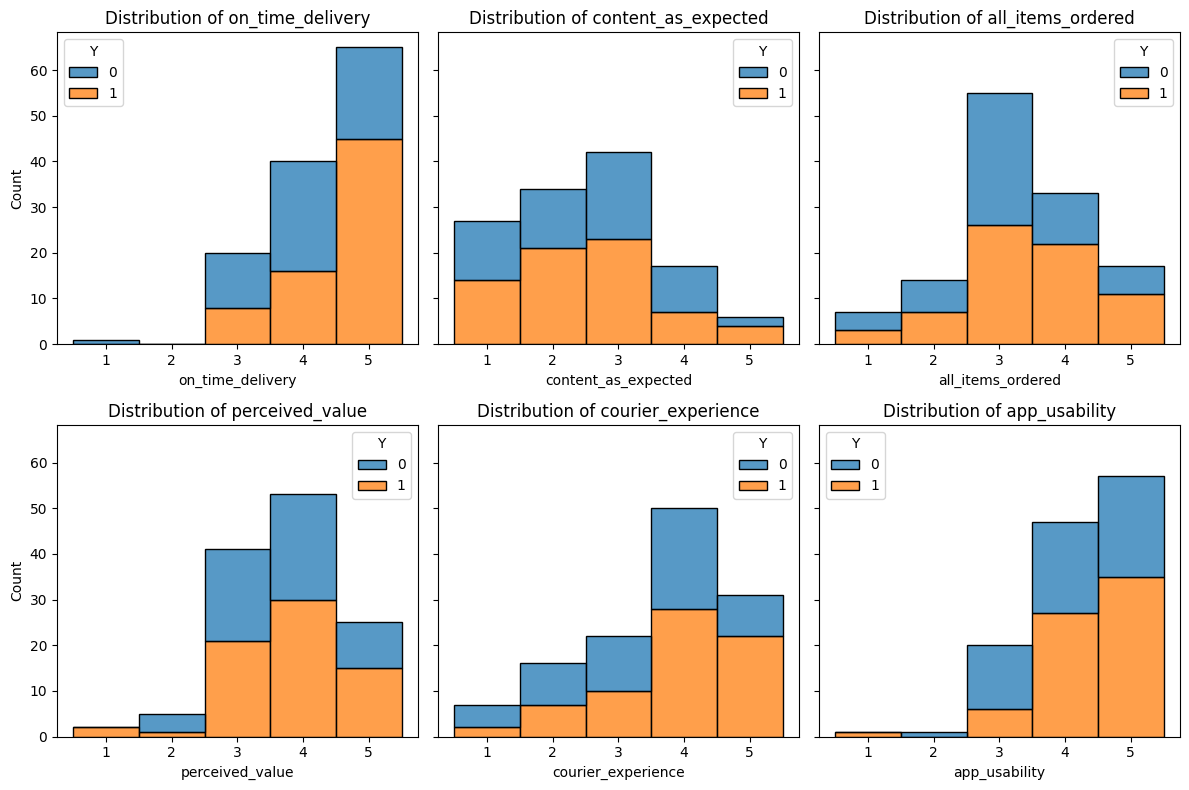

In [28]:
cols = X.columns.tolist()

fig, axes = plt.subplots(
    nrows=2, ncols=3,
    figsize=(12, 8),
    sharey=True
)
axes = axes.flatten()

for ax, col in zip(axes, cols):
    sns.histplot(
        data=survey_data,
        x=col,
        hue='Y',
        multiple='stack',
        discrete=True,
        ax=ax
    )
    ax.set_title(f'Distribution of {col}')
    ax.set_ylabel('Count')

for ax in axes[len(cols):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

We can see that,


1.   Very few people gave low ratings for on time delivery, app usability, and to some extent, percieved value
2.   giving high scores on on time delivery and courier experience corresponds to a higher percentage of happy customers

Let's now see the pairwise correlation between the variables

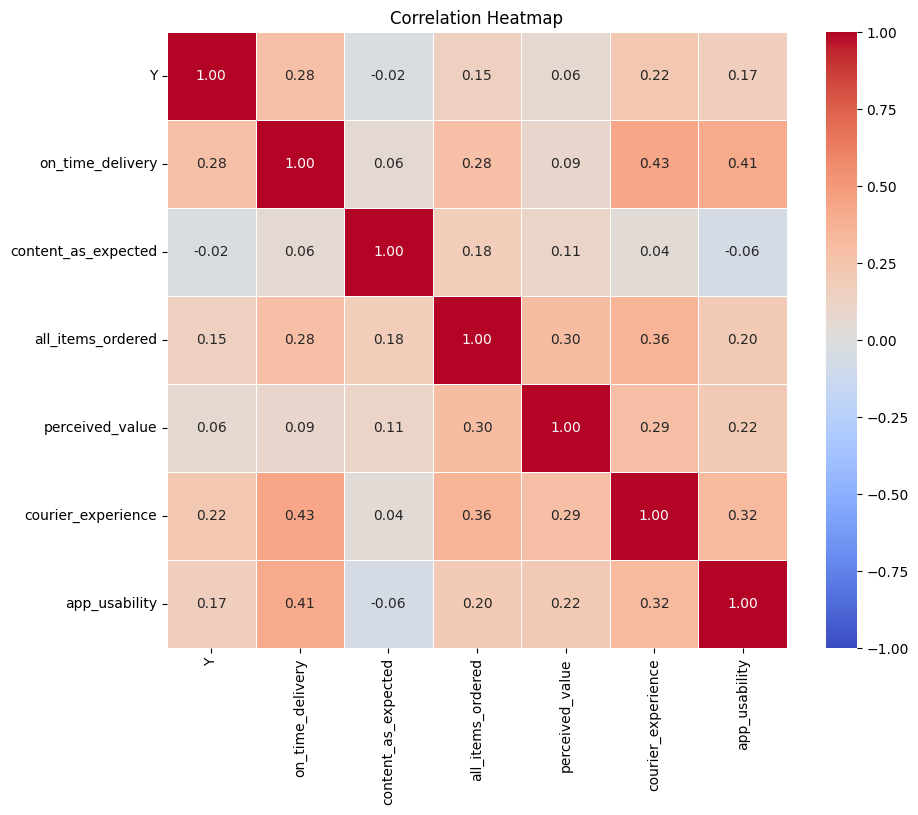

In [29]:
corr = survey_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5
)
plt.title('Correlation Heatmap')
plt.show()

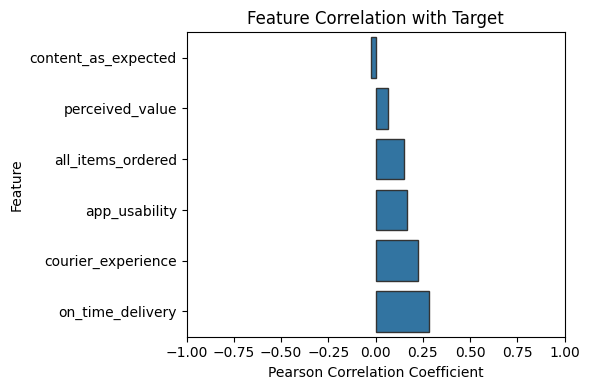

In [30]:
corr_with_target = corr['Y'].drop('Y').sort_values()

plt.figure(figsize=(6, 4))
sns.barplot(
    x=corr_with_target.values,
    y=corr_with_target.index,
    orient='h',
    edgecolor=".2"
)
plt.title("Feature Correlation with Target")
plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Feature")
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

on time delivery and courier experience have the highest correlation with customer being happy. Now let's see if we can predict if a customer is happy with only these two.

## Feature Engineering and Model

In [31]:
X2 = X.copy()
X2 = X[['on_time_delivery', 'courier_experience']]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X2, Y,
    test_size=0.2,
    random_state=42
)

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [22]:
test_models(models, X_train, X_test, y_train, y_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Hold-out Acc
0,Logistic Regression,0.461538
1,Random Forest,0.730769
2,SVC,0.576923
3,XGBoost,0.730769


Keeping only two variables we were able to reach 73% accuracy with random forest and xgboost.

## Results and Conclusion



*   The baseline accuracy for the winning models was around 60% to 45%
*   The survey has 6 different questions each having 5 possible values, approx. 15,000 combinations
*   with only 127 records and so many possible combinations, we have too many features
*   One possible solution was too find the questions that have the highest correlation with the target -a customer being happy
*   Finally, we can say that a customer being happy has a lot to do with timely delivery and courier experience. For the furture, we can keep those questions inthe survey and remove the rest




### Future Directions:

We can further explore options to reduce dimensionality, for example combining answer values together where they make little impact on the target. For example in some questions giving 4 or 5 doesn't make a difference. Or in some others giving a very high or a very low rating is significant, and the mid values show indifference.





